In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [2]:

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [3]:
# Paths
data_dir = 'data/training'  # Folder with .tif images
csv_file = 'data/training.csv'  # CSV file with image_id and is_homogeneous


In [5]:
# Load the CSV file
df = pd.read_csv(csv_file)
df.columns = df.columns.str.strip()
df.rename(columns={'is_homogenous': 'is_homogeneous'}, inplace=True)


In [6]:
df.head()

,image_id,is_homogeneous
0,279,0
1,277,0
2,275,0
3,273,0
4,271,0


In [7]:
# Create image paths and labels
image_paths = [os.path.join(data_dir, f"{str(image_id).zfill(3)}.tif") for image_id in df['image_id']]
labels = df['is_homogeneous'].values

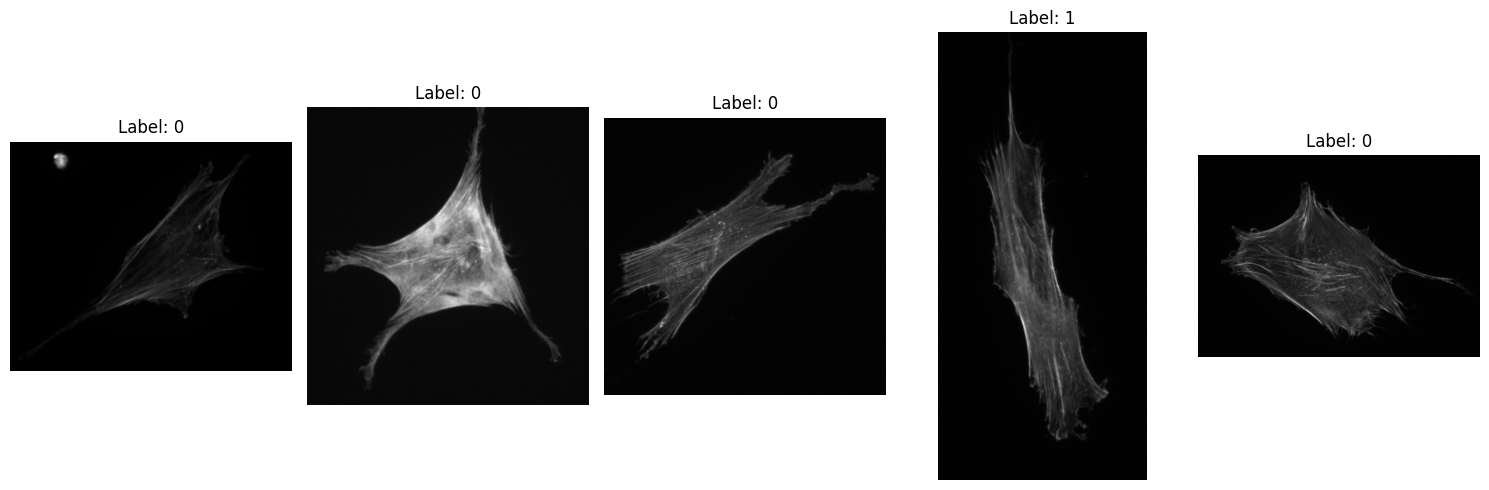

In [8]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Number of random samples to take
num_samples = 5

# Randomly select 5 indices
random_indices = random.sample(range(len(image_paths)), num_samples)

# Plot the selected images and their labels
plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    img_path = image_paths[idx]
    label = labels[idx]

    # Load image
    img = mpimg.imread(img_path)

    # Create subplot for each image
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img, cmap='gray')  # Assuming grayscale images, adjust cmap if necessary
    plt.title(f"Label: {label}")
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [9]:
# Stratify split to maintain class distribution
train_paths, val_paths, y_train, y_val = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

In [10]:
# Convert labels to numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)

In [11]:
# Separate majority and minority classes
train_paths_majority = [path for path, label in zip(train_paths, y_train) if label == 0]
train_labels_majority = [0] * len(train_paths_majority)

train_paths_minority = [path for path, label in zip(train_paths, y_train) if label == 1]
train_labels_minority = [1] * len(train_paths_minority)


In [12]:
print(f"Majority class samples: {len(train_labels_majority)}")
print(f"Minority class samples: {len(train_labels_minority)}")

Majority class samples: 92
Minority class samples: 19


In [13]:
# Calculate the number of augmented images needed
num_majority_samples = len(train_labels_majority)
num_minority_samples = len(train_labels_minority)
num_augmented_images_needed = num_majority_samples - num_minority_samples


In [ ]:
print(f"Number of augmented images needed: {num_augmented_images_needed}")


Number of augmented images needed: 73


In [ ]:
augment_times = num_augmented_images_needed // num_minority_samples + 1
augment_times
print(f"Number of times to augment: {augment_times}")


Number of times to augment: 4


In [ ]:
augment_times = 5

In [14]:
# Define transforms
# Common transformations for all datasets
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize as per ImageNet
                         std=[0.229, 0.224, 0.225])
])

In [15]:
# Augmentation transformations for the augmented dataset
augmentation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [16]:
# Define custom datasets
class CellDataset(Dataset):
    def __init__(self, image_paths, labels, transform=common_transforms):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform  # Use common transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(image_path)
            # Convert image to RGB if it's not already
            if image.mode != 'RGB':
                image = image.convert('RGB')

            # Apply transforms
            if self.transform:
                image = self.transform(image)

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise e

        return image, label

In [17]:
class AugmentedDataset(Dataset):
    def __init__(self, image_paths, labels, augment_times=1, transform=augmentation_transforms, rotation_interval=1):
        self.image_paths = image_paths
        self.labels = labels
        self.augment_times = augment_times
        self.transform = transform  # Use augmentation transforms
        self.rotation_interval = rotation_interval

    def __len__(self):
        return len(self.image_paths) * self.augment_times * (360 // self.rotation_interval)

    def __getitem__(self, idx):
        actual_idx = idx % len(self.image_paths)
        image_path = self.image_paths[actual_idx]
        label = self.labels[actual_idx]

        try:
            image = Image.open(image_path)
            # Convert image to RGB if it's not already
            if image.mode != 'RGB':
                image = image.convert('RGB')

            # Apply transforms
            if self.transform:
                image = self.transform(image)

            # Apply additional rotations
            rotation_angle = self.rotation_interval * (idx // len(self.image_paths) % (360 // self.rotation_interval))
            image = transforms.functional.rotate(image, rotation_angle)

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise e

        return image, label

In [18]:
# Create datasets
majority_dataset = AugmentedDataset(
    train_paths_majority,
    train_labels_majority,
    augment_times=1,
    rotation_interval=4
)
minority_dataset = AugmentedDataset(
    train_paths_minority,
    train_labels_minority,
    augment_times=1,
    rotation_interval=1
)


In [19]:
# Combine datasets using ConcatDataset
train_dataset = ConcatDataset([majority_dataset, minority_dataset])

In [20]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = CellDataset(val_paths, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [21]:
# Test data loading
for i, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {i+1}")
    print(f"Inputs type: {type(inputs)}, Inputs shape: {inputs.shape}")
    print(f"Labels type: {type(labels)}, Labels shape: {labels.shape}")
    break  # Test with the first batch



Batch 1
Inputs type: <class 'torch.Tensor'>, Inputs shape: torch.Size([32, 3, 224, 224])
Labels type: <class 'torch.Tensor'>, Labels shape: torch.Size([32])


In [30]:
# Check lengths of datasets
len_majority_dataset = len(majority_dataset)
len_minority_dataset = len(train_paths_minority)
len_train_dataset = len(train_dataset)

print(f"Length of Majority Dataset: {len_majority_dataset}")
print(f"Length of Minority Dataset (before augmentation): {len_minority_dataset}")
print(f"Length of Combined Training Dataset: {len_train_dataset}")

# Verify class balance in the combined training dataset
count_class_0 = 0
count_class_1 = 0

for _, label in train_dataset:
    if label == 0:
        count_class_0 += 1
    elif label == 1:
        count_class_1 += 1

print(f"Number of Majority Class Samples in Training Dataset: {count_class_0}")
print(f"Number of Minority Class Samples in Training Dataset: {count_class_1}")

Length of Majority Dataset: 8280
Length of Minority Dataset (before augmentation): 19
Length of Combined Training Dataset: 15120


KeyboardInterrupt: 

In [22]:

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Adjust the input size based on your specific input image size
        self.fc2 = nn.Linear(128, 1)  # Assuming binary classification

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [23]:
model = CustomCNN()

In [24]:
# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [25]:
# Define loss function, optimizer, and scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)


In [26]:
# Training loop
num_epochs = 30
best_val_loss = np.inf
early_stopping_patience = 5
epochs_no_improve = 0

In [31]:
import torch.nn.functional as F
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))  # Assuming binary classification

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels.unsqueeze(1))  # Assuming binary classification

            val_running_loss += val_loss.item() * inputs.size(0)

    val_loss = val_running_loss / len(val_loader.dataset)

    # Adjust learning rate
    scheduler.step(val_loss)

    # Print statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model1.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print('Early stopping!')
            break

Epoch 1/30, Training Loss: 0.4832, Validation Loss: 0.5255
Epoch 2/30, Training Loss: 0.4765, Validation Loss: 0.5173
Epoch 3/30, Training Loss: 0.4732, Validation Loss: 0.5260
Epoch 4/30, Training Loss: 0.4717, Validation Loss: 0.5341
Epoch 5/30, Training Loss: 0.4721, Validation Loss: 0.5034
Epoch 6/30, Training Loss: 0.4703, Validation Loss: 0.5162
Epoch 7/30, Training Loss: 0.4701, Validation Loss: 0.5142
Epoch 8/30, Training Loss: 0.4696, Validation Loss: 0.4852
Epoch 9/30, Training Loss: 0.4830, Validation Loss: 0.4991
Epoch 10/30, Training Loss: 0.4703, Validation Loss: 0.4861
Epoch 11/30, Training Loss: 0.4698, Validation Loss: 0.4958
Epoch 12/30, Training Loss: 0.4690, Validation Loss: 0.5070
Epoch 13/30, Training Loss: 0.4685, Validation Loss: 0.4892
Early stopping!


In [32]:
model.eval()

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [33]:
# Evaluate on validation set
all_preds = []
all_labels = []

In [34]:
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)

        outputs = model(inputs)
        outputs = outputs.view(-1)

        preds = (outputs >= 0.5).long().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

In [35]:
print(classification_report(all_labels, all_preds, target_names=['Heterogeneous', 'Homogeneous']))


               precision    recall  f1-score   support

Heterogeneous       0.82      1.00      0.90        23
  Homogeneous       0.00      0.00      0.00         5

     accuracy                           0.82        28
    macro avg       0.41      0.50      0.45        28
 weighted avg       0.67      0.82      0.74        28



/home/cogu/.conda/envs/pytorch_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cogu/.conda/envs/pytorch_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cogu/.conda/envs/pytorch_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()